In [1]:
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras import layers, models, backend as K
from tensorflow.keras.layers import Layer, Dropout, BatchNormalization





In [2]:
data = pd.read_excel("1390_train_data.xlsx")
df = pd.DataFrame(data)
data.head()

,Additive concentration,MAI,FAI,CsI,CsBr,MABr,MACl,PbI2,PbBr2,PbCl2,...,DMF,DMSO,GBL,Polarity index,Annealing tem,Etl,Htl,Back contact,Interlayer,PCE (%)
0,0,0.0,0.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.8,0.2,0.0,2.7,1.0,6,8,1,2,5.200
1,0,0.0,0.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.8,0.2,0.0,2.7,1.0,6,8,1,2,4.828
2,0,0.0,0.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.8,0.2,0.0,2.7,1.0,6,8,1,2,4.836
3,0,0.0,0.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.8,0.2,0.0,2.7,1.0,6,8,1,2,5.070
4,0,0.0,0.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.8,0.2,0.0,2.7,1.0,6,8,1,2,4.980


In [3]:
print(df.isnull().sum())

Additive concentration    0
MAI                       0
FAI                       0
CsI                       0
CsBr                      0
MABr                      0
MACl                      0
PbI2                      0
PbBr2                     0
PbCl2                     0
SnI2                      0
SnCl2                     0
SnBr2                     0
Pb(SCN)2                  0
SnF2                      0
DMF                       0
DMSO                      0
GBL                       0
Polarity index            0
Annealing tem             0
Etl                       0
Htl                       0
Back contact              0
Interlayer                0
PCE (%)                   0
dtype: int64


In [4]:
X = df.drop(['PCE (%)'], axis= 1)
y = df['PCE (%)']
print(X.shape, y.shape)

(1390, 24) (1390,)


In [5]:
data = df

print(data.shape)

(1390, 25)


In [6]:
data = df.values.astype(np.float32)


In [7]:

class VAEConfig:
    input_dim = 25
    latent_dim = 40  
    hidden_dims = [512, 256,128, 64, 32]  
    dropout_rate = 0.2  
    batch_size = 32  
    epochs = 500  
    lr = 0.0001  
    beta = 1  


class AdvancedSampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = K.random_normal(shape=(batch, dim))
        return z_mean + K.exp(0.5 * z_log_var) * epsilon



def build_encoder(config):
    inputs = layers.Input(shape=(config.input_dim,))
    x = inputs

    for dim in config.hidden_dims:
        x = layers.Dense(dim, activation='swish')(x)
        x = BatchNormalization()(x)
        x = Dropout(config.dropout_rate)(x)

    z_mean = layers.Dense(config.latent_dim)(x)
    z_log_var = layers.Dense(config.latent_dim)(x)
    z = AdvancedSampling()([z_mean, z_log_var])

    return models.Model(inputs, [z_mean, z_log_var, z], name='encoder')



def build_decoder(config):
    latent_inputs = layers.Input(shape=(config.latent_dim,))
    x = latent_inputs

    for dim in reversed(config.hidden_dims):
        x = layers.Dense(dim, activation='swish')(x)
        x = BatchNormalization()(x)
        x = Dropout(config.dropout_rate)(x)

    outputs = layers.Dense(config.input_dim, activation='linear')(x)  
    return models.Model(latent_inputs, outputs, name='decoder')


class VAEModel(models.Model):
    def __init__(self, encoder, decoder, config, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.config = config
        self.beta = config.beta
        self.total_loss_tracker = tf.keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = tf.keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")
        self.current_epoch = tf.Variable(0, trainable=False, dtype=tf.int32)  

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        return self.decoder(z)

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        x = data
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(x)
            reconstruction = self.decoder(z)

            reconstruction_loss = tf.reduce_mean(tf.reduce_sum(tf.square(x - reconstruction), axis=1)) / self.config.input_dim

            kl_loss = -0.5 * tf.reduce_mean(
                1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            )


            total_loss = reconstruction_loss + self.beta * kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        self.current_epoch.assign_add(1)

        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
            "beta": self.beta,
        }

    def test_step(self, data):
        x = data
        z_mean, z_log_var, z = self.encoder(x)
        reconstruction = self.decoder(z)

        reconstruction_loss = tf.reduce_mean(tf.reduce_sum(tf.square(x - reconstruction), axis=1)) / self.config.input_dim

        kl_loss = -0.5 * tf.reduce_mean(
            1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
        )

        

        total_loss = reconstruction_loss + self.beta * kl_loss

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
            "beta": self.beta,
        }



config = VAEConfig()
encoder = build_encoder(config)
decoder = build_decoder(config)
vae = VAEModel(encoder, decoder, config)
vae.compile(optimizer=tf.keras.optimizers.Adam(config.lr, clipvalue=1.0)) 



vae.fit(data, epochs=config.epochs, batch_size=config.batch_size, validation_split=0.2)




Epoch 1/500
35/35 [==============================] - 2s 8ms/step - loss: 10.0815 - reconstruction_loss: 9.6055 - kl_loss: 0.0999 - beta: 1.0000 - val_loss: 8.6431 - val_reconstruction_loss: 7.9323 - val_kl_loss: 0.7108 - val_beta: 1.0000
Epoch 2/500
35/35 [==============================] - 0s 3ms/step - loss: 5.7025 - reconstruction_loss: 2.8828 - kl_loss: 1.3870 - beta: 1.0000 - val_loss: 2.2698 - val_reconstruction_loss: 1.3787 - val_kl_loss: 0.8912 - val_beta: 1.0000
Epoch 3/500
35/35 [==============================] - 0s 3ms/step - loss: 2.2333 - reconstruction_loss: 1.5569 - kl_loss: 0.5875 - beta: 1.0000 - val_loss: 1.7935 - val_reconstruction_loss: 1.2072 - val_kl_loss: 0.5863 - val_beta: 1.0000
Epoch 4/500
35/35 [==============================] - 0s 3ms/step - loss: 1.9773 - reconstruction_loss: 1.4104 - kl_loss: 0.4949 - beta: 1.0000 - val_loss: 1.6367 - val_reconstruction_loss: 1.1228 - val_kl_loss: 0.5139 - val_beta: 1.0000
Epoch 5/500
35/35 [==============================] 

In [8]:
def generate_samples(model, num_samples=200):
    z_samples = np.random.normal(size=(num_samples, config.latent_dim))
    return model.decoder.predict(z_samples)

In [9]:
generated_samples = generate_samples(vae, num_samples=200)

print("generated samples:")
print(generated_samples)


print(f"mean: {np.mean(generated_samples, axis=0)}")

print(f"Standard deviation: {np.std(generated_samples, axis=0)}")

7/7 [==============================] - 0s 1ms/step
generated samples:
[[ 2.6337242   0.18900582  0.8732869  ...  0.7064217   0.4944144
  20.108599  ]
 [ 0.31855682  0.43025222  0.4930951  ...  0.23337522 -0.38750225
  12.074601  ]
 [ 0.93839264  0.8687689   0.46062234 ...  1.2087283   2.838425
  14.174535  ]
 ...
 [ 0.02310844  0.02451357  0.39604986 ...  0.71732265  0.19685431
  11.833202  ]
 [-0.4319003   0.8787438   0.298263   ...  1.118107    1.4052094
  12.993599  ]
 [ 0.42993763  0.6202137   0.38955462 ...  0.73588806  0.8507952
   6.9349046 ]]
mean: [ 1.1033825e+00  5.0433224e-01  4.4516954e-01  7.5259633e-02
  7.0715849e-03  3.4844127e-02  6.6151572e-03  7.5653160e-01
  5.7265453e-02  4.8434217e-03  2.7561566e-01  1.4019563e-02
  3.4205033e-03 -6.4640259e-03  2.0296248e-02  5.9212339e-01
  3.3595914e-01  8.6143255e-02  2.3746052e+00  1.0465335e+00
  3.8337879e+00  5.6955175e+00  8.6811030e-01  1.1724825e+00
  1.1710407e+01]
Standard deviation: [1.3978115  0.34016547 0.25277787 

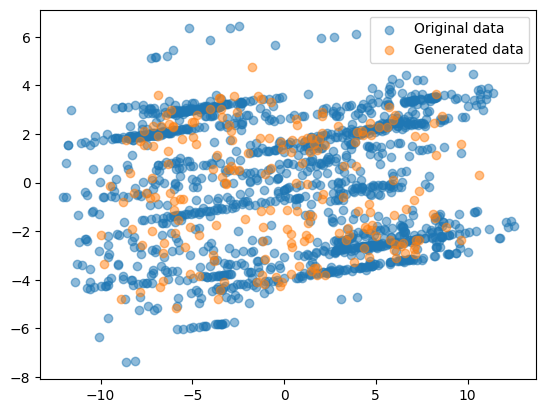

In [10]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
pca = PCA(n_components=2)
original_2d = pca.fit_transform(data)
generated_2d = pca.transform(generated_samples)

plt.scatter(original_2d[:, 0], original_2d[:, 1], label="Original data", alpha=0.5)
plt.scatter(generated_2d[:, 0], generated_2d[:, 1], label="Generated data", alpha=0.5)
plt.legend()
plt.show()

In [11]:
generated_samples[generated_samples<0] = 0

# Maximum Mean Discrepancy (MMD) calculating :

In [13]:
import numpy as np
from sklearn.gaussian_process.kernels import RBF


def compute_mmd(X, Y, gamma=None):
    if gamma is None:
        gamma = 1.0 / X.shape[1]
    
    kernel = RBF(length_scale=gamma)
    K_XX = kernel(X, X)
    K_YY = kernel(Y, Y)
    K_XY = kernel(X, Y)
    
    mmd_sq = np.mean(K_XX) + np.mean(K_YY) - 2 * np.mean(K_XY)
    return np.sqrt(max(mmd_sq, 0))

print("=" * 70)
print("ANALYSIS OF YOUR SPECIFIC DATA")
print("=" * 70)


print(f"Real data shape: {data.shape}")
print(f"Generated data shape: {generated_samples.shape}")

n_samples = min(200, len(data), len(generated_samples))
real_sample = data[:n_samples]
gen_sample = generated_samples[:n_samples]

mmd_value = compute_mmd(real_sample, gen_sample)

print(f"\nMMD Calculation (using {n_samples} samples):")
print(f"MMD = {mmd_value:.4f}")

print(f"\nDescriptive Statistics:")
print(f"{'Metric':<15} {'Real Data':>15} {'Generated':>15} {'Difference':>15}")
print("-" * 70)

real_mean = np.mean(data)
real_std = np.std(data)
real_min = np.min(data)
real_max = np.max(data)

gen_mean = np.mean(generated_samples)
gen_std = np.std(generated_samples)
gen_min = np.min(generated_samples)
gen_max = np.max(generated_samples)

stats = [
    ("Mean", real_mean, gen_mean),
    ("Std", real_std, gen_std),
    ("Min", real_min, gen_min),
    ("Max", real_max, gen_max),
    ("25th %", np.percentile(data, 25), np.percentile(generated_samples, 25)),
    ("50th %", np.percentile(data, 50), np.percentile(generated_samples, 50)),
    ("75th %", np.percentile(data, 75), np.percentile(generated_samples, 75))
]

for name, real_val, gen_val in stats:
    diff = abs(real_val - gen_val)
    print(f"{name:<15} {real_val:>15.4f} {gen_val:>15.4f} {diff:>15.4f}")



results = {
    'mmd': mmd_value,
    'real_stats': {
        'n_samples': len(data),
        'mean': real_mean,
        'std': real_std,
        'min': real_min,
        'max': real_max
    },
    'gen_stats': {
        'n_samples': len(generated_samples),
        'mean': gen_mean,
        'std': gen_std,
        'min': gen_min,
        'max': gen_max
    },
   
}

print(f"\nResults. MMD = {results['mmd']:.4f}")

ANALYSIS OF YOUR SPECIFIC DATA
Real data shape: (1390, 25)
Generated data shape: (200, 25)

MMD Calculation (using 200 samples):
MMD = 0.1344

Descriptive Statistics:
Metric                Real Data       Generated      Difference
----------------------------------------------------------------------
Mean                     1.2841          1.2465          0.0376
Std                      2.9581          2.7839          0.1743
Min                      0.0000          0.0000          0.0000
Max                     24.3300         22.4040          1.9260
25th %                   0.0000          0.0095          0.0095
50th %                   0.0000          0.1865          0.1865
75th %                   1.0000          1.0209          0.0209

Results. MMD = 0.1344


# Fréchet Distance (FID)

In [ ]:
import numpy as np
from scipy.linalg import sqrtm

def calculate_frechet_distance(mu1, sigma1, mu2, sigma2, eps=1e-6):
    
    diff = mu1 - mu2
    
    # Covariance might be singular, add small epsilon
    sigma1 = sigma1 + eps * np.eye(len(sigma1))
    sigma2 = sigma2 + eps * np.eye(len(sigma2))
    
    # Matrix square root of product
    covmean = sqrtm(sigma1.dot(sigma2))
    
    # Numerical stability
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    
    fd = diff.dot(diff) + np.trace(sigma1 + sigma2 - 2 * covmean)
    
    return np.real(fd)

def calculate_statistics(data):
    """
    Calculate mean and covariance for Frechet Distance
    """
    mu = np.mean(data, axis=0)
    sigma = np.cov(data.T)
    return mu, sigma

def comprehensive_frechet_analysis(real_data, gen_data, n_iterations=10):
    """
    Comprehensive Frechet Distance analysis
    """
    print("=" * 80)
    print("FRECHET DISTANCE (FD) ANALYSIS")
    print("=" * 80)
    
    fd_values = []
    
    for i in range(n_iterations):
        # Random sampling for fair comparison
        n_samples = min(200, len(real_data), len(gen_data))
        real_idx = np.random.choice(len(real_data), n_samples, replace=False)
        gen_idx = np.random.choice(len(gen_data), n_samples, replace=False)
        
        real_sample = real_data[real_idx]
        gen_sample = gen_data[gen_idx]
        
        # Calculate statistics
        mu_real, sigma_real = calculate_statistics(real_sample)
        mu_gen, sigma_gen = calculate_statistics(gen_sample)
        
        # Calculate Fréchet Distance
        fd = calculate_frechet_distance(mu_real, sigma_real, mu_gen, sigma_gen)
        fd_values.append(fd)
        
        print(f"Iteration {i+1}: FD = {fd:.4f}")
    
    fd_array = np.array(fd_values)
    
    print(f"\n" + "-" * 80)
    print("FRECHET DISTANCE RESULTS")
    print("-" * 80)
    print(f"Mean FD: {np.mean(fd_array):.4f} ± {np.std(fd_array):.4f}")
    print(f"Range: [{np.min(fd_array):.4f}, {np.max(fd_array):.4f}]")
    print(f"95% CI: [{np.percentile(fd_array, 2.5):.4f}, {np.percentile(fd_array, 97.5):.4f}]")
    
    # Interpretation
    mean_fd = np.mean(fd_array)
    print(f"\nINTERPRETATION:")
    print("-" * 40)
    
    if mean_fd < 10:
        interpretation = "Excellent similarity"
        grade = "A+"
    elif mean_fd < 20:
        interpretation = "Very good"
        grade = "A"
    elif mean_fd < 40:
        interpretation = "Good"
        grade = "B"
    elif mean_fd < 60:
        interpretation = "Acceptable"
        grade = "C"
    else:
        interpretation = "Needs improvement"
        grade = "D"
    
    print(f"FD = {mean_fd:.2f} - {interpretation} (Grade: {grade})")
    
    # Compare with MMD
    print(f"\nCOMPARISON WITH MMD:")
    print("-" * 40)
    print("FD measures distance between Gaussian approximations")
    print("MMD measures distance between actual distributions")
    print("Both metrics should correlate for valid evaluation")
    
    return {
        'fd_mean': mean_fd,
        'fd_std': np.std(fd_array),
        'fd_values': fd_values,
        'interpretation': interpretation,
        'grade': grade
    }


fd_results = comprehensive_frechet_analysis(data, generated_samples, n_iterations=10)

FRÉCHET DISTANCE (FD) ANALYSIS
Iteration 1: FD = 2.6217
Iteration 2: FD = 3.1186
Iteration 3: FD = 2.7179
Iteration 4: FD = 3.0049
Iteration 5: FD = 2.8849
Iteration 6: FD = 2.4287
Iteration 7: FD = 2.7309
Iteration 8: FD = 2.8454
Iteration 9: FD = 2.7737
Iteration 10: FD = 2.9906

--------------------------------------------------------------------------------
FRÉCHET DISTANCE RESULTS
--------------------------------------------------------------------------------
Mean FD: 2.8117 ± 0.1922
Range: [2.4287, 3.1186]
95% CI: [2.4721, 3.0930]

INTERPRETATION:
----------------------------------------
FD = 2.81 - Excellent similarity (Grade: A+)

COMPARISON WITH MMD:
----------------------------------------
FD measures distance between Gaussian approximations
MMD measures distance between actual distributions
Both metrics should correlate for valid evaluation


# Silhouette Score and Davies–Bouldin Index

SILHOUETTE SCORE AND CLUSTERING ANALYSIS
COMPREHENSIVE CLUSTERING ANALYSIS
Using 5 clusters for analysis

1. OPTIMAL CLUSTER ANALYSIS
----------------------------------------
Real data optimal clusters: 4
  • Elbow method: 4
  • Silhouette method: 2
Generated data optimal clusters: 3
  • Elbow method: 3
  • Silhouette method: 2

2. CLUSTERING METRICS (using 5 clusters)
----------------------------------------
Metric                    Real Data       Generated Data  Difference     
------------------------- --------------- --------------- ---------------
Silhouette Score          0.346           0.295           0.052 (14.9%)
Davies-Bouldin Index      1.188           1.164           0.98 ratio

3. CLUSTER SIZE DISTRIBUTION
----------------------------------------
Cluster    Real Size       Generated Size  Size Ratio     
0          162             48              0.30
1          107             56              0.52
2          75              31              0.41
3          85           

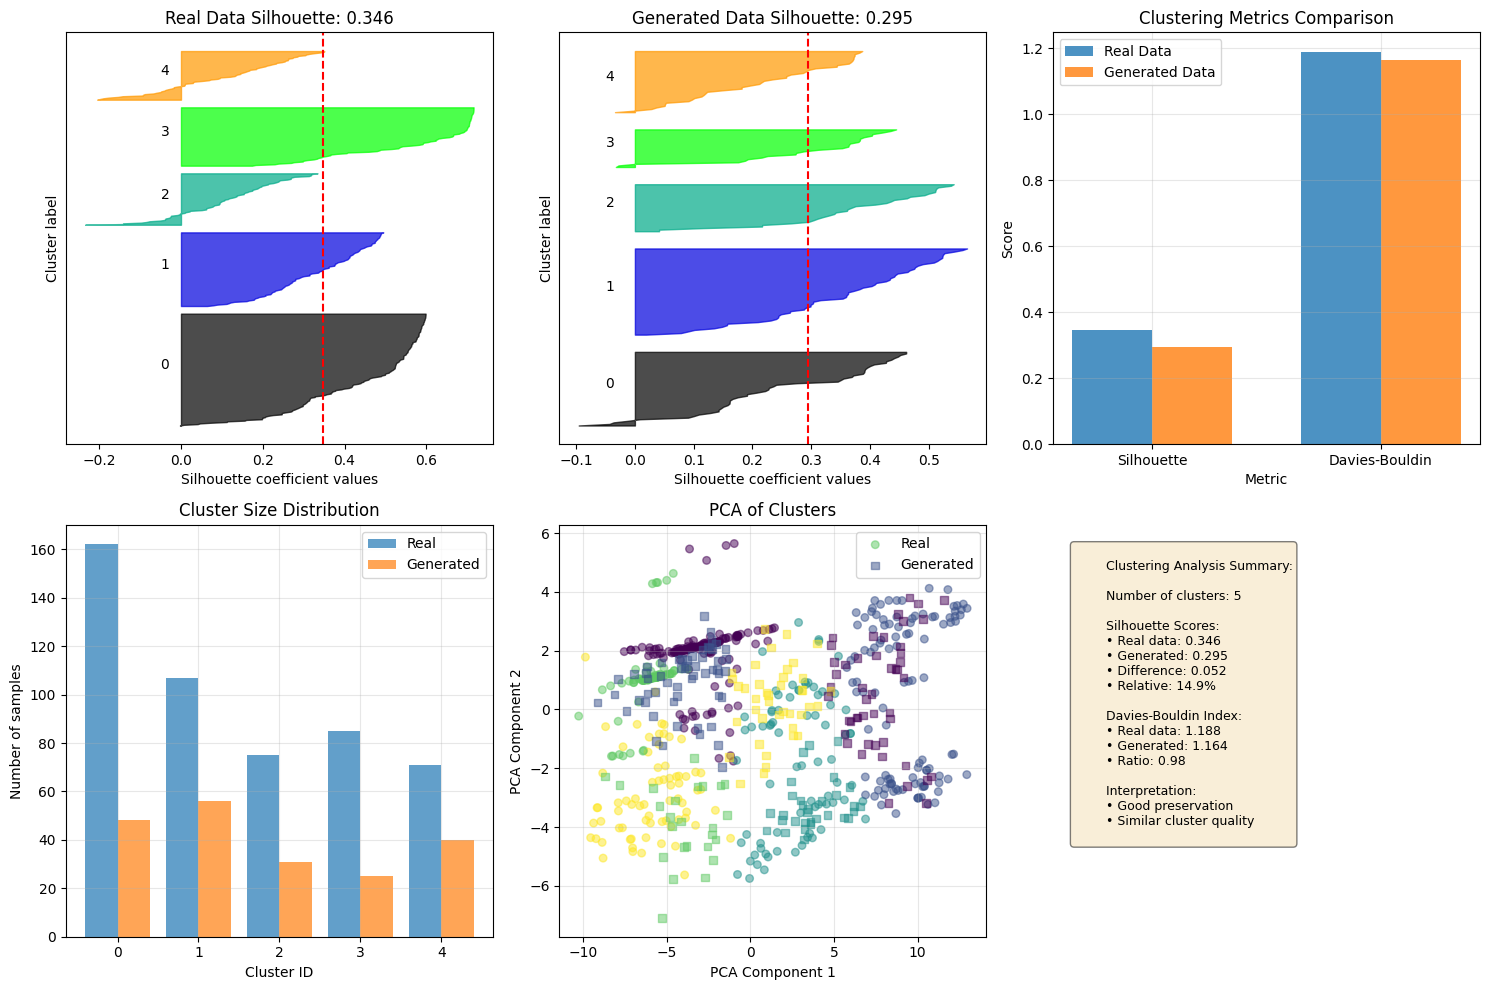

In [ ]:
import numpy as np
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from scipy import stats

class ClusteringMetrics:
    
    
    def __init__(self, real_data, gen_data, max_clusters=10):
        self.real_data = real_data
        self.gen_data = gen_data
        self.max_clusters = max_clusters
        
    def optimal_clusters_elbow(self, data, max_clusters=None):
        

        if max_clusters is None:
            max_clusters = self.max_clusters
            
        inertias = []
        silhouette_scores = []
        
        for k in range(2, max_clusters + 1):
            kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
            labels = kmeans.fit_predict(data)
            
            inertias.append(kmeans.inertia_)
            silhouette_scores.append(silhouette_score(data, labels))
            
        # Find elbow point
        deltas = np.diff(inertias)
        deltas2 = np.diff(deltas)
        elbow_point = np.argmax(deltas2) + 3 if len(deltas2) > 0 else 3
        
        # Find max silhouette
        optimal_silhouette = np.argmax(silhouette_scores) + 2
        
        return {
            'inertias': inertias,
            'silhouette_scores': silhouette_scores,
            'elbow_point': min(elbow_point, max_clusters),
            'optimal_silhouette': optimal_silhouette,
            'optimal_k': max(optimal_silhouette, elbow_point)
        }
    
    def calculate_silhouette_analysis(self, n_clusters=None):
        
        # Determine optimal clusters if not provided
        if n_clusters is None:
            real_optimal = self.optimal_clusters_elbow(self.real_data[:500])['optimal_k']
            gen_optimal = self.optimal_clusters_elbow(self.gen_data)['optimal_k']
            n_clusters = max(3, min(real_optimal, gen_optimal, 8))
        
        print(f"Using {n_clusters} clusters for analysis")
        
        # Cluster both datasets
        kmeans_real = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
        kmeans_gen = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
        
        labels_real = kmeans_real.fit_predict(self.real_data[:500])
        labels_gen = kmeans_gen.fit_predict(self.gen_data)
        
        # Calculate silhouette scores
        silhouette_real = silhouette_score(self.real_data[:500], labels_real)
        silhouette_gen = silhouette_score(self.gen_data, labels_gen)
        
        # Calculate per-sample silhouette scores
        from sklearn.metrics import silhouette_samples
        sample_silhouette_real = silhouette_samples(self.real_data[:500], labels_real)
        sample_silhouette_gen = silhouette_samples(self.gen_data, labels_gen)
        
        # Davies-Bouldin Index
        db_real = davies_bouldin_score(self.real_data[:500], labels_real)
        db_gen = davies_bouldin_score(self.gen_data, labels_gen)
        
        # Cluster statistics
        cluster_stats = {
            'real': {
                'cluster_sizes': np.bincount(labels_real),
                'cluster_means': [self.real_data[:500][labels_real == i].mean(axis=0) for i in range(n_clusters)],
                'cluster_stds': [self.real_data[:500][labels_real == i].std(axis=0) for i in range(n_clusters)]
            },
            'gen': {
                'cluster_sizes': np.bincount(labels_gen),
                'cluster_means': [self.gen_data[labels_gen == i].mean(axis=0) for i in range(n_clusters)],
                'cluster_stds': [self.gen_data[labels_gen == i].std(axis=0) for i in range(n_clusters)]
            }
        }
        
        return {
            'n_clusters': n_clusters,
            'silhouette': {
                'real': silhouette_real,
                'generated': silhouette_gen,
                'difference': abs(silhouette_real - silhouette_gen),
                'relative_difference': abs(silhouette_real - silhouette_gen) / silhouette_real * 100,
                'sample_scores_real': sample_silhouette_real,
                'sample_scores_gen': sample_silhouette_gen
            },
            'davies_bouldin': {
                'real': db_real,
                'generated': db_gen,
                'ratio': db_gen / db_real if db_real > 0 else float('inf')
            },
            'clusters': {
                'labels_real': labels_real,
                'labels_gen': labels_gen,
                'centers_real': kmeans_real.cluster_centers_,
                'centers_gen': kmeans_gen.cluster_centers_,
                'stats': cluster_stats
            }
        }
    
    def visualize_results(self, results):
        
        fig, axes = plt.subplots(2, 3, figsize=(15, 10))
        
        # 1. Silhouette plot for real data
        ax = axes[0, 0]
        n_clusters = results['n_clusters']
        labels_real = results['clusters']['labels_real']
        sample_silhouette_real = results['silhouette']['sample_scores_real']
        
        y_lower = 10
        for i in range(n_clusters):
            ith_cluster_silhouette_values = sample_silhouette_real[labels_real == i]
            ith_cluster_silhouette_values.sort()
            
            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i
            
            color = plt.cm.nipy_spectral(float(i) / n_clusters)
            ax.fill_betweenx(np.arange(y_lower, y_upper),
                            0, ith_cluster_silhouette_values,
                            facecolor=color, edgecolor=color, alpha=0.7)
            
            ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10
        
        ax.axvline(x=results['silhouette']['real'], color="red", linestyle="--")
        ax.set_xlabel("Silhouette coefficient values")
        ax.set_ylabel("Cluster label")
        ax.set_title(f"Real Data Silhouette: {results['silhouette']['real']:.3f}")
        ax.set_yticks([])
        
        # 2. Silhouette plot for generated data
        ax = axes[0, 1]
        labels_gen = results['clusters']['labels_gen']
        sample_silhouette_gen = results['silhouette']['sample_scores_gen']
        
        y_lower = 10
        for i in range(n_clusters):
            ith_cluster_silhouette_values = sample_silhouette_gen[labels_gen == i]
            ith_cluster_silhouette_values.sort()
            
            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i
            
            color = plt.cm.nipy_spectral(float(i) / n_clusters)
            ax.fill_betweenx(np.arange(y_lower, y_upper),
                            0, ith_cluster_silhouette_values,
                            facecolor=color, edgecolor=color, alpha=0.7)
            
            ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10
        
        ax.axvline(x=results['silhouette']['generated'], color="red", linestyle="--")
        ax.set_xlabel("Silhouette coefficient values")
        ax.set_ylabel("Cluster label")
        ax.set_title(f"Generated Data Silhouette: {results['silhouette']['generated']:.3f}")
        ax.set_yticks([])
        
        # 3. Comparison bar plot
        ax = axes[0, 2]
        metrics = ['Silhouette', 'Davies-Bouldin']
        real_values = [results['silhouette']['real'], results['davies_bouldin']['real']]
        gen_values = [results['silhouette']['generated'], results['davies_bouldin']['generated']]
        
        x = np.arange(len(metrics))
        width = 0.35
        
        ax.bar(x - width/2, real_values, width, label='Real Data', alpha=0.8)
        ax.bar(x + width/2, gen_values, width, label='Generated Data', alpha=0.8)
        
        ax.set_xlabel('Metric')
        ax.set_ylabel('Score')
        ax.set_title('Clustering Metrics Comparison')
        ax.set_xticks(x)
        ax.set_xticklabels(metrics)
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # 4. Cluster size comparison
        ax = axes[1, 0]
        real_sizes = results['clusters']['stats']['real']['cluster_sizes']
        gen_sizes = results['clusters']['stats']['gen']['cluster_sizes']
        
        x = np.arange(n_clusters)
        ax.bar(x - 0.2, real_sizes, 0.4, label='Real', alpha=0.7)
        ax.bar(x + 0.2, gen_sizes, 0.4, label='Generated', alpha=0.7)
        
        ax.set_xlabel('Cluster ID')
        ax.set_ylabel('Number of samples')
        ax.set_title('Cluster Size Distribution')
        ax.set_xticks(x)
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # 5. PCA visualization
        from sklearn.decomposition import PCA
        pca = PCA(n_components=2)
        
        # Combine data for consistent transformation
        combined = np.vstack([self.real_data[:500], self.gen_data])
        pca.fit(combined)
        
        real_pca = pca.transform(self.real_data[:500])
        gen_pca = pca.transform(self.gen_data)
        
        ax = axes[1, 1]
        scatter1 = ax.scatter(real_pca[:, 0], real_pca[:, 1], 
                             c=labels_real, cmap='viridis', 
                             alpha=0.5, label='Real', s=30)
        scatter2 = ax.scatter(gen_pca[:, 0], gen_pca[:, 1], 
                             c=labels_gen, cmap='viridis', 
                             alpha=0.5, label='Generated', s=30, marker='s')
        
        ax.set_xlabel('PCA Component 1')
        ax.set_ylabel('PCA Component 2')
        ax.set_title('PCA of Clusters')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # 6. Statistical comparison
        ax = axes[1, 2]
        ax.axis('off')
        
        summary_text = f"""
        Clustering Analysis Summary:
        
        Number of clusters: {n_clusters}
        
        Silhouette Scores:
        • Real data: {results['silhouette']['real']:.3f}
        • Generated: {results['silhouette']['generated']:.3f}
        • Difference: {results['silhouette']['difference']:.3f}
        • Relative: {results['silhouette']['relative_difference']:.1f}%
        
        Davies-Bouldin Index:
        • Real data: {results['davies_bouldin']['real']:.3f}
        • Generated: {results['davies_bouldin']['generated']:.3f}
        • Ratio: {results['davies_bouldin']['ratio']:.2f}
        
        Interpretation:
        • {'Good preservation' if results['silhouette']['relative_difference'] < 20 else 'Moderate preservation'}
        • {'Similar cluster quality' if 0.8 < results['davies_bouldin']['ratio'] < 1.2 else 'Different cluster structure'}
        """
        
        ax.text(0.05, 0.95, summary_text, transform=ax.transAxes,
                verticalalignment='top', fontsize=9,
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
        
        plt.tight_layout()
        plt.show()
        
        return fig
    
    def generate_report(self, n_clusters=5):
       
        print("=" * 80)
        print("COMPREHENSIVE CLUSTERING ANALYSIS")
        print("=" * 80)
        
        # Calculate metrics
        results = self.calculate_silhouette_analysis(n_clusters)
        
        print(f"\n1. OPTIMAL CLUSTER ANALYSIS")
        print("-" * 40)
        
        # Find optimal clusters for both datasets
        real_optimal = self.optimal_clusters_elbow(self.real_data[:500])
        gen_optimal = self.optimal_clusters_elbow(self.gen_data)
        
        print(f"Real data optimal clusters: {real_optimal['optimal_k']}")
        print(f"   Elbow method: {real_optimal['elbow_point']}")
        print(f"  Silhouette method: {real_optimal['optimal_silhouette']}")
        print(f"Generated data optimal clusters: {gen_optimal['optimal_k']}")
        print(f"   Elbow method: {gen_optimal['elbow_point']}")
        print(f"  Silhouette method: {gen_optimal['optimal_silhouette']}")
        
        print(f"\n2. CLUSTERING METRICS (using {results['n_clusters']} clusters)")
        print("-" * 40)
        
        print(f"{'Metric':<25} {'Real Data':<15} {'Generated Data':<15} {'Difference':<15}")
        print(f"{'-'*25:<25} {'-'*15:<15} {'-'*15:<15} {'-'*15:<15}")
        
        # Silhouette Score
        sil_diff = results['silhouette']['difference']
        sil_rel = results['silhouette']['relative_difference']
        print(f"{'Silhouette Score':<25} {results['silhouette']['real']:<15.3f} {results['silhouette']['generated']:<15.3f} {sil_diff:.3f} ({sil_rel:.1f}%)")
        
        # Davies-Bouldin
        db_ratio = results['davies_bouldin']['ratio']
        print(f"{'Davies-Bouldin Index':<25} {results['davies_bouldin']['real']:<15.3f} {results['davies_bouldin']['generated']:<15.3f} {db_ratio:.2f} ratio")
        
        # Cluster sizes
        print(f"\n3. CLUSTER SIZE DISTRIBUTION")
        print("-" * 40)
        
        real_sizes = results['clusters']['stats']['real']['cluster_sizes']
        gen_sizes = results['clusters']['stats']['gen']['cluster_sizes']
        
        print(f"{'Cluster':<10} {'Real Size':<15} {'Generated Size':<15} {'Size Ratio':<15}")
        for i in range(results['n_clusters']):
            ratio = gen_sizes[i] / real_sizes[i] if real_sizes[i] > 0 else float('inf')
            print(f"{i:<10} {real_sizes[i]:<15} {gen_sizes[i]:<15} {ratio:.2f}")
        
        print(f"\n4. INTERPRETATION")
        print("-" * 40)
        
        # Silhouette interpretation
        sil_real = results['silhouette']['real']
        sil_gen = results['silhouette']['generated']
        
        def interpret_silhouette(score):
            if score >= 0.7:
                return "Strong structure"
            elif score >= 0.5:
                return "Reasonable structure"
            elif score >= 0.25:
                return "Weak structure"
            else:
                return "No substantial structure"
        
        print(f"Silhouette Score Interpretation:")
        print(f"   Real data ({sil_real:.3f}): {interpret_silhouette(sil_real)}")
        print(f"  Generated ({sil_gen:.3f}): {interpret_silhouette(sil_gen)}")
        print(f"  Preservation: {100 - sil_rel:.1f}% of structure preserved")
        
        # Davies-Bouldin interpretation
        db_ratio = results['davies_bouldin']['ratio']
        if 0.8 < db_ratio < 1.2:
            db_interp = "Excellent preservation of cluster compactness"
        elif 0.6 < db_ratio < 1.4:
            db_interp = "Good preservation"
        elif 0.4 < db_ratio < 1.6:
            db_interp = "Moderate preservation"
        else:
            db_interp = "Different cluster structure"
        
        print(f"\nDavies-Bouldin Interpretation:")
        print(f"  Ratio: {db_ratio:.2f} - {db_interp}")
        
        print(f"\n5. SCIENTIFIC IMPLICATIONS")
        print("-" * 40)
        
        
        
        # Visualize results
        print(f"\nGenerating visualizations...")
        self.visualize_results(results)
        
        return results

print("SILHOUETTE SCORE AND CLUSTERING ANALYSIS")
print("=" * 80)

# real_data = data
# gen_data = generated_samples

analyzer = ClusteringMetrics(data, generated_samples, max_clusters=8)

results = analyzer.generate_report(n_clusters=5)



COMPREHENSIVE VAE RECONSTRUCTION ERROR ANALYSIS

1. Reconstructing all samples...
2. Calculating per-sample reconstruction errors...
3. Computing error statistics...
4. Identifying outliers...
5. Analyzing error distribution in PCA space...

6. Generating comprehensive report...

ERROR DISTRIBUTION STATISTICS

Sample Reconstruction Errors (n=1390)
--------------------------------------------------
Metric          Mean       Std        Median     Min        Max       
--------------- ---------- ---------- ---------- ---------- ----------
MSE             0.138125   0.132200   0.100371   0.004412   1.354576  
MAE             0.194855   N/A        0.17944931983947754 N/A        N/A       
RMSE            0.339627   N/A        N/A        N/A        N/A       

Outlier Analysis:
- Number of outliers: 68 (4.89%)
- Outlier range: [0.376483, 1.354576]
- IQR boundaries: [-0.146645, 0.376432]

7. Creating visualizations...


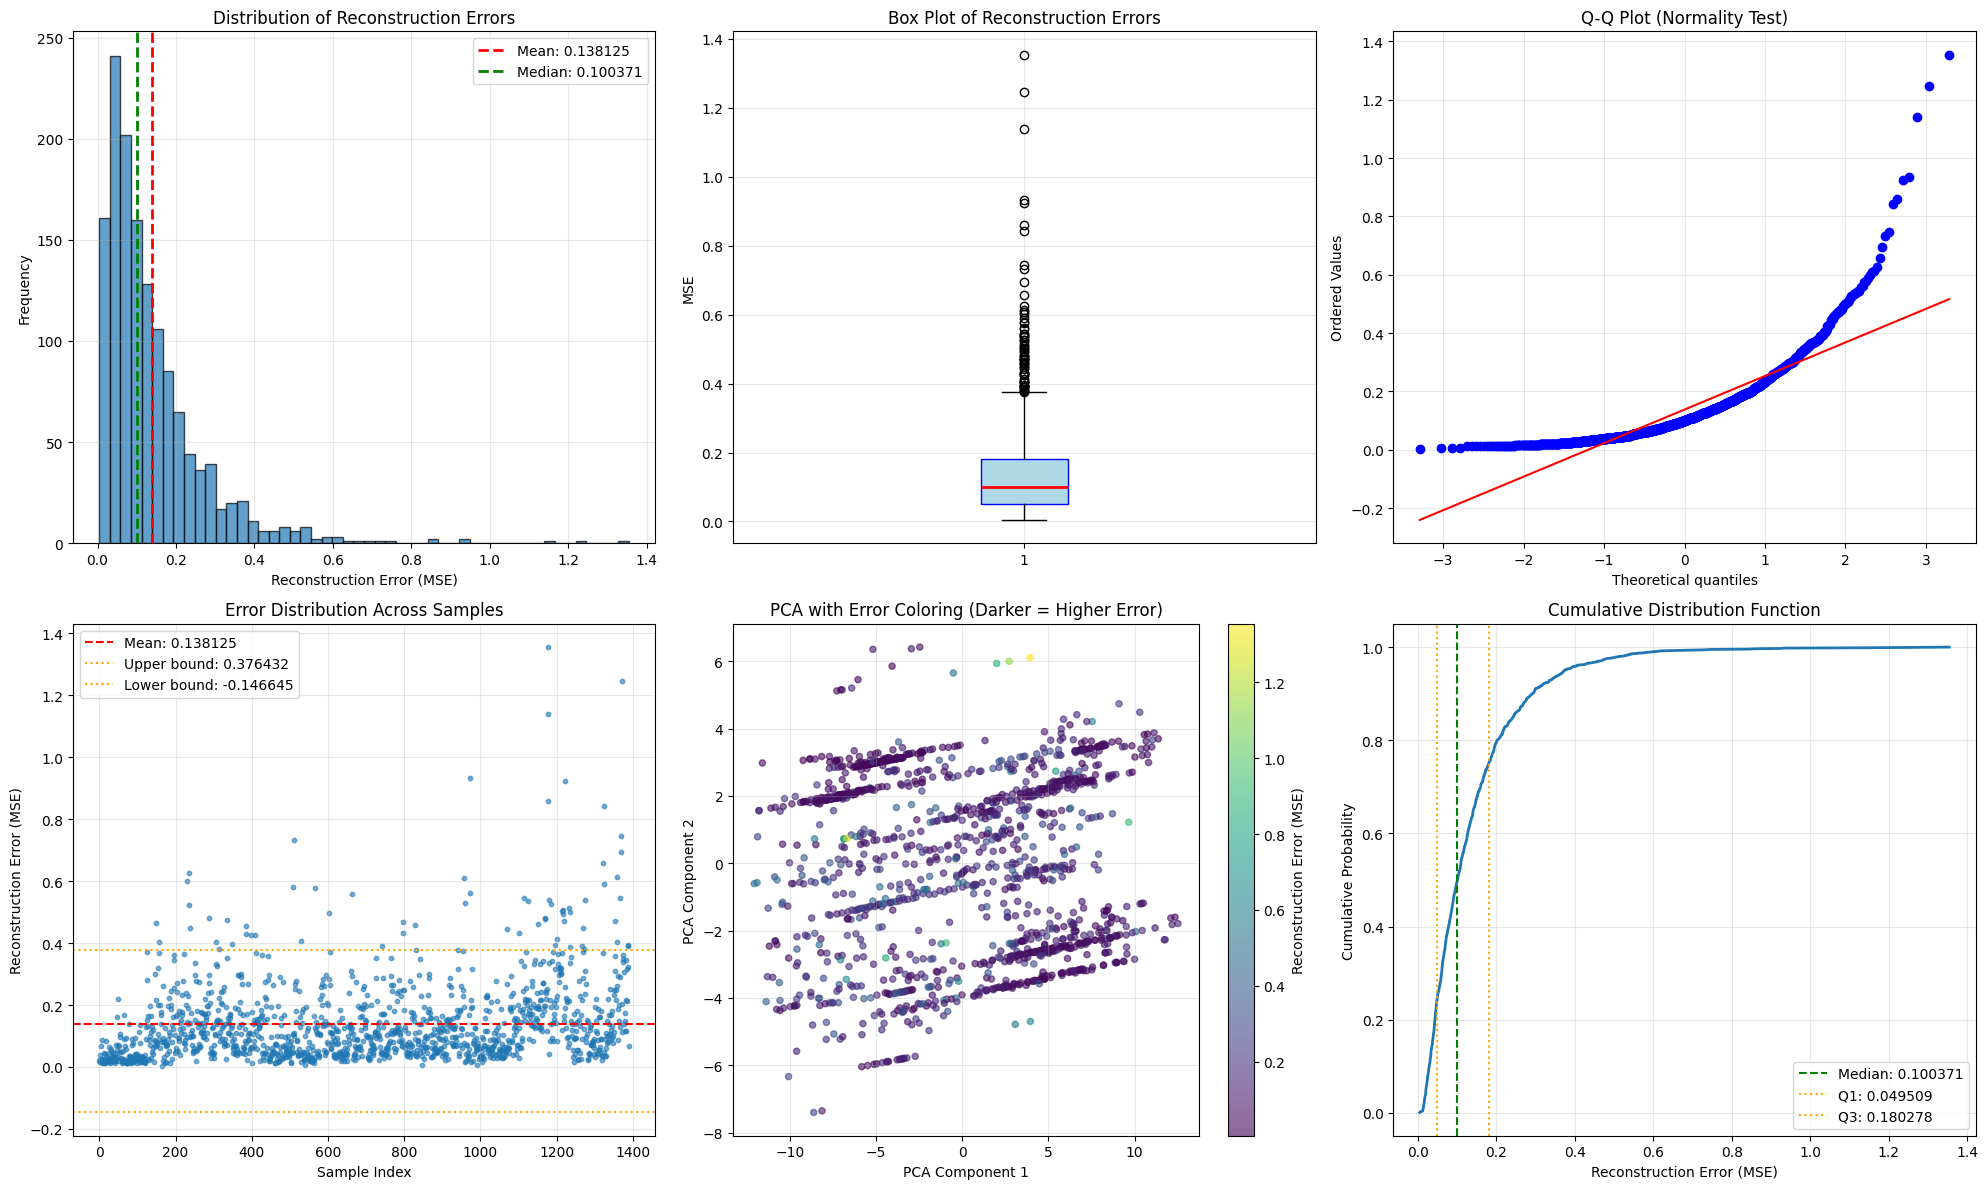


8. Clustering analysis of error patterns...

ERROR PATTERN CLUSTERING

Cluster 0:
  Size: 564 samples (40.6%)
  Mean error: 0.128338
  Median error: 0.096081
  Error std: 0.128646

Cluster 1:
  Size: 462 samples (33.2%)
  Mean error: 0.127212
  Median error: 0.074548
  Error std: 0.135999

Cluster 2:
  Size: 364 samples (26.2%)
  Mean error: 0.167141
  Median error: 0.133763
  Error std: 0.128367

Analysis complete! Results saved to 'vae_error_analysis_results.pkl'


In [15]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats  
from sklearn.decomposition import PCA

def analyze_vae_reconstruction_errors(vae_model, original_data, batch_size=32):
    
    print("=" * 80)
    print("COMPREHENSIVE VAE RECONSTRUCTION ERROR ANALYSIS")
    print("=" * 80)
    
    print("\n1. Reconstructing all samples...")
    reconstructed_data = vae_model.predict(original_data, batch_size=batch_size, verbose=0)
    
    print("2. Calculating per-sample reconstruction errors...")
    
    mse_per_sample = np.mean((original_data - reconstructed_data)**2, axis=1)
    
    mae_per_sample = np.mean(np.abs(original_data - reconstructed_data), axis=1)
    
    rmse_per_sample = np.sqrt(mse_per_sample)
    
    print("3. Computing error statistics...")
    
    error_stats = {
        'MSE': {
            'values': mse_per_sample,
            'mean': np.mean(mse_per_sample),
            'std': np.std(mse_per_sample),
            'median': np.median(mse_per_sample),
            'min': np.min(mse_per_sample),
            'max': np.max(mse_per_sample),
            'q1': np.percentile(mse_per_sample, 25),
            'q3': np.percentile(mse_per_sample, 75),
            'iqr': np.percentile(mse_per_sample, 75) - np.percentile(mse_per_sample, 25),
            'skewness': stats.skew(mse_per_sample),
            'kurtosis': stats.kurtosis(mse_per_sample),
            'cv': (np.std(mse_per_sample) / np.mean(mse_per_sample) * 100) if np.mean(mse_per_sample) > 0 else 0
        },
        'MAE': {
            'values': mae_per_sample,
            'mean': np.mean(mae_per_sample),
            'median': np.median(mae_per_sample)
        },
        'RMSE': {
            'values': rmse_per_sample,
            'mean': np.mean(rmse_per_sample)
        }
    }
    
    print("4. Identifying outliers...")
    
    q1, q3 = error_stats['MSE']['q1'], error_stats['MSE']['q3']
    iqr = error_stats['MSE']['iqr']
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    
    outlier_mask = (mse_per_sample < lower_bound) | (mse_per_sample > upper_bound)
    outliers = mse_per_sample[outlier_mask]
    outlier_indices = np.where(outlier_mask)[0]
    
    error_stats['MSE']['outliers'] = outliers
    error_stats['MSE']['outlier_indices'] = outlier_indices
    error_stats['MSE']['outlier_percentage'] = len(outliers) / len(mse_per_sample) * 100
    
    print("5. Analyzing error distribution in PCA space...")
    
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(original_data)
    
    print("\n6. Generating comprehensive report...")
    
    print(f"\n{'='*60}")
    print("ERROR DISTRIBUTION STATISTICS")
    print(f"{'='*60}")
    
    print(f"\nSample Reconstruction Errors (n={len(mse_per_sample)})")
    print(f"{'-'*50}")
    
    print(f"{'Metric':<15} {'Mean':<10} {'Std':<10} {'Median':<10} {'Min':<10} {'Max':<10}")
    print(f"{'-'*15:<15} {'-'*10:<10} {'-'*10:<10} {'-'*10:<10} {'-'*10:<10} {'-'*10:<10}")
    
    for metric in ['MSE', 'MAE', 'RMSE']:
        stats_dict = error_stats[metric]
        if metric == 'MSE':
            print(f"{metric:<15} {stats_dict['mean']:<10.6f} {stats_dict['std']:<10.6f} "
                  f"{stats_dict['median']:<10.6f} {stats_dict['min']:<10.6f} {stats_dict['max']:<10.6f}")
        else:
            print(f"{metric:<15} {stats_dict['mean']:<10.6f} {'N/A':<10} "
                  f"{stats_dict.get('median', 'N/A'):<10} {'N/A':<10} {'N/A':<10}")
    
    print(f"\nOutlier Analysis:")
    print(f"- Number of outliers: {len(outliers)} ({error_stats['MSE']['outlier_percentage']:.2f}%)")
    print(f"- Outlier range: [{np.min(outliers):.6f}, {np.max(outliers):.6f}]" if len(outliers) > 0 else "- No outliers found")
    print(f"- IQR boundaries: [{lower_bound:.6f}, {upper_bound:.6f}]")
    
    print("\n7. Creating visualizations...")
    
    fig = plt.figure(figsize=(20, 12))
    
    ax1 = plt.subplot(2, 3, 1)
    n, bins, patches = ax1.hist(mse_per_sample, bins=50, alpha=0.7, edgecolor='black')
    ax1.axvline(error_stats['MSE']['mean'], color='red', linestyle='--', linewidth=2, label=f'Mean: {error_stats["MSE"]["mean"]:.6f}')
    ax1.axvline(error_stats['MSE']['median'], color='green', linestyle='--', linewidth=2, label=f'Median: {error_stats["MSE"]["median"]:.6f}')
    ax1.set_xlabel('Reconstruction Error (MSE)')
    ax1.set_ylabel('Frequency')
    ax1.set_title('Distribution of Reconstruction Errors')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    ax2 = plt.subplot(2, 3, 2)
    bp = ax2.boxplot(mse_per_sample, vert=True, patch_artist=True, 
                     boxprops=dict(facecolor='lightblue', color='blue'),
                     medianprops=dict(color='red', linewidth=2))
    ax2.set_ylabel('MSE')
    ax2.set_title('Box Plot of Reconstruction Errors')
    ax2.grid(True, alpha=0.3)
    
    ax3 = plt.subplot(2, 3, 3)
    stats.probplot(mse_per_sample, dist="norm", plot=ax3)
    ax3.set_title('Q-Q Plot (Normality Test)')
    ax3.grid(True, alpha=0.3)
    
    ax4 = plt.subplot(2, 3, 4)
    ax4.scatter(range(len(mse_per_sample)), mse_per_sample, alpha=0.6, s=10)
    ax4.axhline(y=error_stats['MSE']['mean'], color='r', linestyle='--', label=f'Mean: {error_stats["MSE"]["mean"]:.6f}')
    ax4.axhline(y=upper_bound, color='orange', linestyle=':', label=f'Upper bound: {upper_bound:.6f}')
    ax4.axhline(y=lower_bound, color='orange', linestyle=':', label=f'Lower bound: {lower_bound:.6f}')
    ax4.set_xlabel('Sample Index')
    ax4.set_ylabel('Reconstruction Error (MSE)')
    ax4.set_title('Error Distribution Across Samples')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    ax5 = plt.subplot(2, 3, 5)
    scatter = ax5.scatter(pca_result[:, 0], pca_result[:, 1], 
                         c=mse_per_sample, cmap='viridis', 
                         alpha=0.6, s=20)
    ax5.set_xlabel('PCA Component 1')
    ax5.set_ylabel('PCA Component 2')
    ax5.set_title('PCA with Error Coloring (Darker = Higher Error)')
    plt.colorbar(scatter, ax=ax5, label='Reconstruction Error (MSE)')
    ax5.grid(True, alpha=0.3)
    
    # Subplot 6: Cumulative distribution
    ax6 = plt.subplot(2, 3, 6)
    sorted_errors = np.sort(mse_per_sample)
    cdf = np.arange(1, len(sorted_errors) + 1) / len(sorted_errors)
    ax6.plot(sorted_errors, cdf, linewidth=2)
    ax6.axvline(x=error_stats['MSE']['median'], color='g', linestyle='--', label=f'Median: {error_stats["MSE"]["median"]:.6f}')
    ax6.axvline(x=error_stats['MSE']['q1'], color='orange', linestyle=':', label=f'Q1: {error_stats["MSE"]["q1"]:.6f}')
    ax6.axvline(x=error_stats['MSE']['q3'], color='orange', linestyle=':', label=f'Q3: {error_stats["MSE"]["q3"]:.6f}')
    ax6.set_xlabel('Reconstruction Error (MSE)')
    ax6.set_ylabel('Cumulative Probability')
    ax6.set_title('Cumulative Distribution Function')
    ax6.legend()
    ax6.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('vae_reconstruction_error_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("\n8. Clustering analysis of error patterns...")
    
    from sklearn.cluster import KMeans
    
    features_for_clustering = np.column_stack([
        mse_per_sample,
        mae_per_sample,
        pca_result[:, 0],
        pca_result[:, 1]
    ])
    
    kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
    error_clusters = kmeans.fit_predict(features_for_clustering)
    
    cluster_error_stats = []
    for cluster_id in range(3):
        cluster_mask = (error_clusters == cluster_id)
        cluster_errors = mse_per_sample[cluster_mask]
        
        cluster_stats = {
            'cluster_id': cluster_id,
            'size': np.sum(cluster_mask),
            'percentage': np.sum(cluster_mask) / len(mse_per_sample) * 100,
            'mean_error': np.mean(cluster_errors),
            'median_error': np.median(cluster_errors),
            'std_error': np.std(cluster_errors)
        }
        cluster_error_stats.append(cluster_stats)
    
    print(f"\n{'='*60}")
    print("ERROR PATTERN CLUSTERING")
    print(f"{'='*60}")
    
    for stats_dict in cluster_error_stats:
        print(f"\nCluster {stats_dict['cluster_id']}:")
        print(f"  Size: {stats_dict['size']} samples ({stats_dict['percentage']:.1f}%)")
        print(f"  Mean error: {stats_dict['mean_error']:.6f}")
        print(f"  Median error: {stats_dict['median_error']:.6f}")
        print(f"  Error std: {stats_dict['std_error']:.6f}")
    
    
    skew_val = error_stats['MSE']['skewness']
    if skew_val > 0.5:
        dist_type = "right-skewed"
    elif skew_val < -0.5:
        dist_type = "left-skewed"
    else:
        dist_type = "approximately symmetric"
    
    cv_val = error_stats['MSE']['cv']
    if cv_val > 50:
        variability = "high"
    elif cv_val > 20:
        variability = "moderate"
    else:
        variability = "low"
    
 

results = analyze_vae_reconstruction_errors(vae, data, batch_size=config.batch_size)

import pickle
with open('vae_error_analysis_results.pkl', 'wb') as f:
    pickle.dump(results, f)

print("\nAnalysis complete! Results saved to 'vae_error_analysis_results.pkl'")